In [1]:
from __future__ import print_function
import sys, os
import glob
import cv2
import numpy as np
import Augmentor
import keras
from keras import *
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
from keras.layers import Input, concatenate,  UpSampling2D, Dropout, Cropping2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.models import Model
from keras.callbacks import EarlyStopping  
from keras.callbacks import ReduceLROnPlateau
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import *

import warnings
warnings.simplefilter("ignore")



Using TensorFlow backend.


In [2]:
dir_nm = 'data'
filenames = []
for root, folders, files in (os.walk(dir_nm)):
    for file in files:      
        if 'raw' in root:
            filenames.append(os.path.join(root, file));

print('# Training images: {}'.format(len(filenames)))
######image size############
img_rows = 128
img_cols = 128
img_channels = 3
SEED=42

# Training images: 367


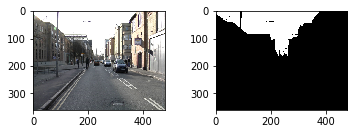

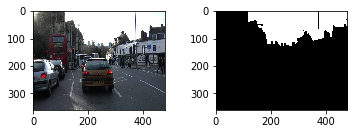

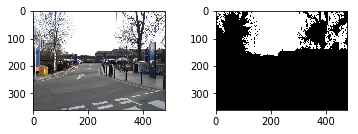

In [3]:
######dataplots#############

n_examples = 3
for i in range(n_examples):
    plt.subplot(2, 2, 1)
    image = cv2.imread(filenames[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

    plt.subplot(2, 2, 2)
    mask_file = filenames[i].replace('raw', 'mask')
    mask = cv2.imread(glob.glob(mask_file[:-4]+'*')[0])
    ret, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY_INV)
    mask = mask[:,:,0]
    plt.imshow((mask), cmap='gray')
    plt.show()
#######################

In [4]:
#########disce coefficient measures##############
def dice_coef(y_true, y_pred, smooth=0.9):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [5]:
##########model##################
inputs = Input((img_rows, img_cols, img_channels))

conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)


conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(inputs = inputs, outputs = conv10)

opt = Adam()
model.compile(optimizer = opt, loss=dice_coef_loss, metrics = [dice_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [6]:
############data tensor###################

X = np.ndarray((len(filenames), img_rows, img_cols , img_channels), dtype=np.uint8)
y = np.ndarray((len(filenames), img_rows, img_cols , 1), dtype=np.uint8)
i=0
for image in filenames:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_rows, img_cols))
    mask_file = image.replace('raw', 'mask')
    label = cv2.imread(glob.glob(mask_file[:-4]+'*')[0], 0)
    ret, label = cv2.threshold(label, 0, 255, cv2.THRESH_BINARY_INV)
    label = cv2.resize(img, (img_rows, img_cols))
    label = label[:,:,0].reshape((img_rows, img_cols, 1))
    img = np.array([img/255.])
    label = np.array([label])
    X[i] = img
    y[i] = label
    i+=1

In [7]:
#############model save#############
weight_saver = ModelCheckpoint('seg.h5', monitor='dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)


In [8]:
###############train model####################
n_epochs = 1
batch_size = 4
history = model.fit(X, y, batch_size=batch_size, epochs=n_epochs, verbose=1,
                     callbacks = [weight_saver, annealer], shuffle=True, validation_split=0.05)

Train on 348 samples, validate on 19 samples
Epoch 1/1
348/348 [==============================] - 157s 451ms/step - loss: -1.0143 - dice_coef: 1.0143 - val_loss: -1.0379 - val_dice_coef: 1.0379


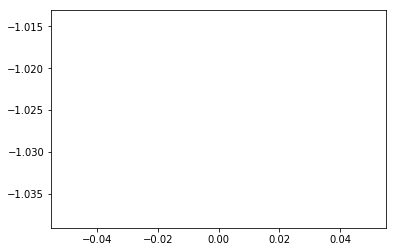

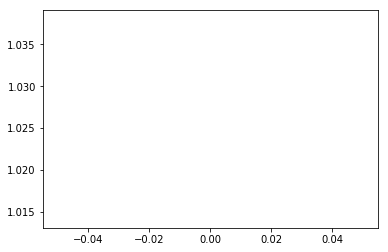

In [9]:
##########performance plots##############
plt.plot(history.history['loss'], color='b')
plt.plot(history.history['val_loss'], color='r')
plt.show()
plt.plot(history.history['dice_coef'], color='b')
plt.plot(history.history['val_dice_coef'], color='r')
plt.show()

In [10]:
#############data normilazation and generator####
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.5)

def data_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=SEED)
    
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=SEED)
    
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch
        

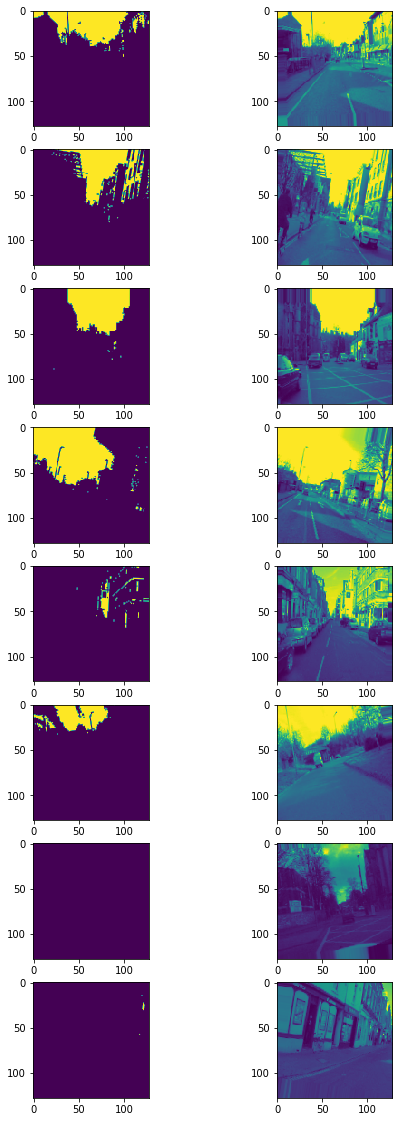

In [11]:
#######train and mask samples##########
image_batch, mask_batch = next(data_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

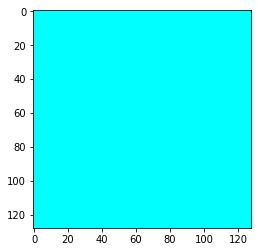

In [12]:
#########loading model and predict a test smaple#######
model.load_weights('seg.h5')
plt.imshow(model.predict(x_train[10].reshape(1,img_rows, img_cols, 3))[0,:,:,0], cmap=plt.cool())

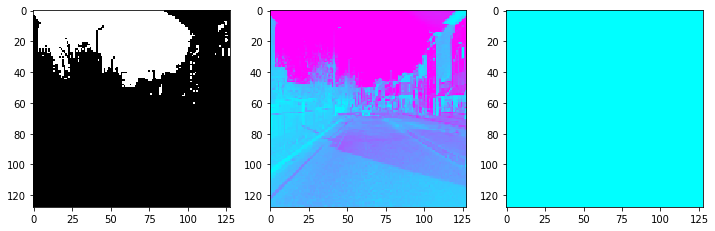

In [13]:
######prediction######
y_hat = model.predict(x_val)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[0,:,:,0], cmap='gray')
ax[1].imshow(y_val[0,:,:,0])
ax[2].imshow(y_hat[0,:,:,0])

In [14]:
#@@@@@End@@@@@@@@@@#